# previoius implementation

In [ ]:
def iou(a, b):
    """Compute the Intersection-Over-Union of two sets of boxes."""
    area_a = (a[:, 3] - a[:, 1]) * (a[:, 2] - a[:, 0])
    area_b = (b[:, 3] - b[:, 1]) * (b[:, 2] - b[:, 0])

    intersection_top_left = torch.max(a[:, None, :2], b[:, :2])
    intersection_bottom_right = torch.min(a[:, None, 2:], b[:, 2:])
    intersection_area = (intersection_bottom_right - intersection_top_left).clamp(min=0).prod(2)

    return intersection_area / (area_a[:, None] + area_b - intersection_area)



def get_precision(predictions, ground_truth, unknown=True):
    # Compute TP and FP for ensemble predictions of the unknown class
    if unknown is not None:
        if unknown:
            ground_truth = [gt for gt in ground_truth if gt['label_id'] == 80]
            predictions = [pred for pred in predictions if pred['label_id'] == 80]
        else: 
            ground_truth = [gt for gt in ground_truth if gt['label_id'] != 80]
            predictions = [pred for pred in predictions if pred['label_id'] != 80]
    tp, fp = compute_tp_fp(predictions, ground_truth)
    
    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return precision
    

def get_recall(predictions, ground_truth, iou_threshold=0.1, unknown=True):
    """Compute recall for the ensemble predictions."""
    if unknown is not None:
        if unknown:
            ground_truth = [gt for gt in ground_truth if gt['label_id'] == 80]
            predictions = [pred for pred in predictions if pred['label_id'] == 80]
        else: 
            ground_truth = [gt for gt in ground_truth if gt['label_id'] != 80]
            predictions = [pred for pred in predictions if pred['label_id'] != 80]
            
    tp, fp = compute_tp_fp(predictions, ground_truth, iou_threshold)
    fn = len(ground_truth) - tp
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return recall


In [31]:
import os

directory_path = "output/from_dataset/filtered_unknown/SOWODB_backup/"

# List all files in the directory
all_files = os.listdir(directory_path)

# Filter the files based on the desired suffix
files = [f.split("_")[0] for f in all_files if f.endswith("t1.pth.txt")]

print(len(files))


4952


In [34]:
unknown_recall = []
known_precision = []
general_recall = []
general_precision = []

for filename in files:
    filepaths = {
    "ground_truth": f"output/from_dataset/filtered_unknown/SOWODB_backup/{filename}_gt.txt",
    "model_1": f"output/from_dataset/filtered_unknown/SOWODB_backup/{filename}_t1.pth.txt",
    }
    # Storing the data from each file in a dictionary
    data = {}
    for key, filepath in filepaths.items():
        with open(filepath, "r") as file:
            data[key] = file.readlines()
    
    h, w = map(int, data["ground_truth"][-1].strip().split(": ")[1].split(", "))
    
    # Displaying the first few lines of each file to understand the data format
    sample_data = {key: value[:5] for key, value in data.items()}
    import re
    import torch
    
    def parse_bbox(tensor_string):
        """Parse tensor string to extract bounding box coordinates."""
        coords = list(map(float, re.findall(r'([-+]?\d*\.\d+e[+-]?\d+|[-+]?\d*\.\d+|[-+]?\d+)', tensor_string)))
        return torch.tensor(coords)
    
    def parse_data_line(line):
        """Parse a line from the data files to extract bounding box, label, ID, and probability."""
        bbox = parse_bbox(re.search(r'tensor\((.*?)\)', line).group(0))
        label = re.search(r'LABEL: (.*?)(?: \(|$)', line).group(1)
        label_id = int(re.search(r'ID: (\d+)', line).group(1))
        prob = float(re. search(r'PROB: (.+)', line).group(1))
        return {'bbox': bbox, 'label': label, 'label_id': label_id, 'prob': prob}
    
    
    # Parsing the data again
    parsed_data = {key: [parse_data_line(line) for line in value[:-1]] for key, value in data.items()}
    unknown_recall.append(get_recall(parsed_data['model_1'], parsed_data['ground_truth'], unknown=True))
    known_precision.append(get_precision(parsed_data['model_1'], parsed_data['ground_truth'], unknown=False))
    # general_recall.append(get_recall(parsed_data['model_1'], parsed_data['ground_truth'], unknown=None))
    # general_precision.append(get_precision(parsed_data['model_1'], parsed_data['ground_truth'], unknown=None))


AttributeError: 'NoneType' object has no attribute 'group'

In [35]:
data

{'ground_truth': ['BBOX: tensor([114.5540, 729.9828, 362.4413, 990.8251]), LABEL: dog (ID: 8), PROB: 1.0\n',
  'BBOX: tensor([ 632.8638,  703.7109,  790.6103, 1000.2078]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([118.3099, 439.1156, 144.6009, 506.6718]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([330.5164, 576.1047, 362.4413, 681.1922]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([ 176.5258,  495.4125,  800.0000, 1182.2344]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([210.3286, 489.7828, 366.1972, 658.6734]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([202.8169, 395.9547, 292.9577, 534.8204]), LABEL: person (ID: 18), PROB: 1.0\n',
  'BBOX: tensor([561.5023, 482.2766, 584.0375, 499.1656]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([550.2347, 425.9797, 593.4272, 510.4250]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  'BBOX: tensor([582.1596, 469.1406, 629.1080, 517.9312]), LABEL: unknown (ID: 80), PROB: 1.0\n',
  

In [29]:
def mean(lst): 
    return sum(lst) / len(lst) 
 
# Driver Code 
print(mean(unknown_recall))
print(mean(known_precision))
print(mean(general_recall))
print(mean(general_precision))

0.14416783837650218
0.5043838308074982
0.36729391147968204
0.2782444016626013


# evaluation

In [1]:
precsion_group = []

In [13]:
import pandas as pd
ground_truth = pd.read_csv("./csv/bbox_data_scaled_gt.csv")
prob_opt_prediction = pd.read_csv("./csv/bbox_data_scaled_opt_v2.csv")
prob_prediction = pd.read_csv("./csv/bbox_data_scaled_opt_v2_top20_50.csv")
custom_01_prediction = pd.read_csv("./csv/bbox_data_scaled_opt_v2_top20_50_predictions_0.01.csv")
custom_03_prediction = pd.read_csv("./csv/bbox_data_scaled_opt_v2_top20_50_predictions_0.03.csv")
custom_05_prediction = pd.read_csv("./csv/bbox_data_scaled_opt_v2_top20_50_predictions_0.05.csv")


In [14]:
import itertools

#OWOD splits
VOC_CLASS_NAMES_COCOFIED = [
    "airplane",  "dining table", "motorcycle",
    "potted plant", "couch", "tv"
]

BASE_VOC_CLASS_NAMES = [
    "aeroplane", "diningtable", "motorbike",
    "pottedplant",  "sofa", "tvmonitor"
]
UNK_CLASS = ["unknown"]

VOC_COCO_CLASS_NAMES={}


T1_CLASS_NAMES = [
    "aeroplane","bicycle","bird","boat","bus","car",
    "cat","cow","dog","horse","motorbike","sheep","train",
    "elephant","bear","zebra","giraffe","truck","person"
]

T2_CLASS_NAMES = [
    "traffic light","fire hydrant","stop sign",
    "parking meter","bench","chair","diningtable",
    "pottedplant","backpack","umbrella","handbag",
    "tie","suitcase","microwave","oven","toaster","sink",
    "refrigerator","bed","toilet","sofa"
]

T3_CLASS_NAMES = [
    "frisbee","skis","snowboard","sports ball",
    "kite","baseball bat","baseball glove","skateboard",
    "surfboard","tennis racket","banana","apple","sandwich",
    "orange","broccoli","carrot","hot dog","pizza","donut","cake"
]

T4_CLASS_NAMES = [
    "laptop","mouse","remote","keyboard","cell phone","book",
    "clock","vase","scissors","teddy bear","hair drier","toothbrush",
    "wine glass","cup","fork","knife","spoon","bowl","tvmonitor","bottle"
]

VOC_COCO_CLASS_NAMES["OWDETR"] = tuple(itertools.chain(T1_CLASS_NAMES, T2_CLASS_NAMES, T3_CLASS_NAMES, T4_CLASS_NAMES, UNK_CLASS))


VOC_CLASS_NAMES = [
"aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
"chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
"pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

VOC_CLASS_NAMES_COCOFIED = [
    "airplane",  "dining table", "motorcycle",
    "potted plant", "couch", "tv"
]

BASE_VOC_CLASS_NAMES = [
    "aeroplane", "diningtable", "motorbike",
    "pottedplant",  "sofa", "tvmonitor"
]

T2_CLASS_NAMES = [
    "truck", "traffic light", "fire hydrant", "stop sign", "parking meter",
    "bench", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase",
    "microwave", "oven", "toaster", "sink", "refrigerator"
]

T3_CLASS_NAMES = [
    "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "banana", "apple", "sandwich", "orange", "broccoli",
    "carrot", "hot dog", "pizza", "donut", "cake"
]

T4_CLASS_NAMES = [
    "bed", "toilet", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "book", "clock",
    "vase", "scissors", "teddy bear", "hair drier", "toothbrush",
    "wine glass", "cup", "fork", "knife", "spoon", "bowl"
]
VOC_COCO_CLASS_NAMES["TOWOD"] = tuple(itertools.chain(VOC_CLASS_NAMES, T2_CLASS_NAMES, T3_CLASS_NAMES, T4_CLASS_NAMES, UNK_CLASS))
VOC_COCO_CLASS_NAMES["VOC2007"] = tuple(itertools.chain(VOC_CLASS_NAMES, T2_CLASS_NAMES, T3_CLASS_NAMES, T4_CLASS_NAMES, UNK_CLASS))



In [85]:
gt_data = ground_truth#[ground_truth['label']!='unknown']
pred_data = prob_prediction#[custom_01_prediction['label']!='unknown']
pred_data

,img_name,x_min,y_min,x_max,y_max,label,prob
0,632,601.1,419.1,640.3,479.3,unknown,0.797
1,632,29.5,76.0,612.8,409.1,unknown,0.773
2,632,154.0,218.4,179.6,228.7,unknown,0.759
3,632,634.2,293.7,640.5,417.2,unknown,0.758
4,632,505.4,295.1,514.5,306.3,unknown,0.758
...,...,...,...,...,...,...,...
995,580294,500.1,1.7,645.9,442.0,unknown,0.740
996,580294,526.9,5.0,641.5,443.4,unknown,0.733
997,580294,0.0,118.9,8.8,449.3,unknown,0.703
998,580294,498.9,48.1,662.2,439.9,unknown,0.694


In [86]:
from datasets.open_world_eval import voc_eval
import torch

from collections import OrderedDict, defaultdict

num_classes = len(VOC_COCO_CLASS_NAMES["OWDETR"])
AP = torch.zeros(num_classes, 1)

all_recs = defaultdict(list)
all_precs = defaultdict(list)
recs = defaultdict(list)
precs = defaultdict(list)
num_unks = defaultdict(list)
unk_det_as_knowns = defaultdict(list)
tp_plus_fp_cs = defaultdict(list)
fp_os = defaultdict(list)

ovthresh = 50

# annopath
annopath_series = '/training_data_2/yuetian/OWOD/Annotations/' + pred_data['img_name'].astype(str).str.zfill(12) + '.xml'
annopath = annopath_series.drop_duplicates().tolist()

# imagesetfile
imagesetfile_series = pred_data['img_name'].astype(str).str.zfill(12)
imagesetfile = imagesetfile_series.drop_duplicates().tolist()

for class_label_ind, class_label in enumerate(VOC_COCO_CLASS_NAMES["OWDETR"]):
    # Vectorized operations for filtering and formatting
    filtered_rows = pred_data[pred_data['label'] == class_label] # label
    
    # detpath
    detpath = (filtered_rows['img_name'].astype(str).str.zfill(12) + ' ' +
               filtered_rows['prob'].astype(str) + ' ' +
               filtered_rows['x_min'].astype(str) + ' ' +
               filtered_rows['y_min'].astype(str) + ' ' +
               filtered_rows['x_max'].astype(str) + ' ' +
               filtered_rows['y_max'].astype(str) + '\n').tolist()

    
    ovthresh_ind, _ = map(list(range(50, 100, 5)).index, [50, 75])
    
    print(class_label + " has " + str(len(detpath)) + " predictions.")

    
    rec, prec, AP[class_label_ind, ovthresh_ind], unk_det_as_known, num_unk, tp_plus_fp_closed_set,fp_open_set = (voc_eval(detpath,
             annopath,
             imagesetfile,
             class_label,
             ovthresh=0.5,
             use_07_metric=True,
             known_classes=T1_CLASS_NAMES))
    print(f"Get AP: {AP[class_label_ind, ovthresh_ind]}")
    AP[class_label_ind, ovthresh_ind] = AP[class_label_ind, ovthresh_ind] * 100
    all_precs[ovthresh].append(prec)
    num_unks[ovthresh].append(num_unk)
    unk_det_as_knowns[ovthresh].append(unk_det_as_known)
    tp_plus_fp_cs[ovthresh].append(tp_plus_fp_closed_set)
    fp_os[ovthresh].append(fp_open_set)
    try:
        recs[ovthresh].append(rec[-1] * 100)
        precs[ovthresh].append(prec[-1] * 100)
    except:
        recs[ovthresh].append(0.)
        precs[ovthresh].append(0.)
    

aeroplane has 0 predictions.
Get AP: 0.0
bicycle has 0 predictions.
Get AP: 0.0
bird has 1 predictions.
Get AP: 1.0
boat has 0 predictions.
Get AP: 0.0
bus has 2 predictions.
Get AP: 1.0
car has 3 predictions.
Get AP: 0.1818181872367859
cat has 0 predictions.
Get AP: 0.0
cow has 0 predictions.
Get AP: 0.0
dog has 0 predictions.
Get AP: 0.0
horse has 0 predictions.
Get AP: 0.0
motorbike has 0 predictions.
Get AP: 0.0
sheep has 0 predictions.
Get AP: 0.0
train has 0 predictions.
Get AP: 0.0
elephant has 2 predictions.
Get AP: 0.4545454680919647
bear has 0 predictions.
Get AP: 0.0
zebra has 0 predictions.
Get AP: 0.0
giraffe has 0 predictions.
Get AP: 0.0
truck has 0 predictions.
Get AP: 0.0
person has 30 predictions.
Get AP: 0.27272728085517883
traffic light has 0 predictions.
Get AP: 0.0
fire hydrant has 0 predictions.
Get AP: 0.0
stop sign has 0 predictions.
Get AP: 0.0
parking meter has 0 predictions.
Get AP: 0.0
bench has 0 predictions.
Get AP: 0.0
chair has 0 predictions.
Get AP: 0.

In [87]:
o50, _ = map(list(range(50, 100, 5)).index, [50, 75])
mAP = float(AP.mean())
mAP50 = float(AP[:, o50].mean())
fmt='{:.06f}'
print('detection mAP50:', fmt.format(mAP50))
print('detection mAP:', fmt.format(mAP))

detection mAP50: 3.595062
detection mAP: 3.595062


In [88]:
print("Known AP50: " + str(AP[:, o50][:19].mean()))

Known AP50: tensor(15.3110)


In [89]:
print("Unknown Recall50: " + str(recs[50][-1]))

Unknown Recall50: 8.583690987124463


In [90]:
print("Precisions50: " + str(['%.1f' % x for x in precs[50]]))

Precisions50: ['0.0', '0.0', '100.0', '0.0', '100.0', '100.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '100.0', '0.0', '0.0', '0.0', '0.0', '96.7', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '2.1']


In [91]:
print("Recall50: " + str(['%.1f' % x for x in recs[50]]))

Recall50: ['0.0', '0.0', '100.0', '0.0', '100.0', '10.3', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '40.0', '0.0', '0.0', '0.0', '0.0', '23.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '8.6']


In [92]:
print("Unknown Precisions50: " + str(precs[50][-1]))

Unknown Precisions50: 2.079002079002079


In [ ]:
print("Unknown Precisions50: " + str(precs[50][-1]))

In [44]:
precsion_group.append(precs)

In [93]:
precsion_group

[defaultdict(list,
             {50: [0.0,
               0.0,
               100.0,
               0.0,
               100.0,
               100.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               100.0,
               0.0,
               0.0,
               0.0,
               0.0,
               96.66666666666667,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               

[0.0, 0.0, 100.0, 0.0, 100.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 96.66666666666667, 2.079002079002079]
[0.0, 0.0, 10.0, 13.157894736842104, 33.33333333333333, 31.818181818181817, 33.33333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.73913043478261, 0.0, 0.0, 0.0, 33.33333333333333, 17.3374613003096, 2.797202797202797]
[0.0, 0.0, 7.142857142857142, 9.803921568627452, 25.0, 20.51282051282051, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.129032258064516, 0.0, 0.0, 0.0, 20.0, 14.251207729468598, 2.797202797202797]
[0.0, 0.0, 3.7037037037037033, 7.8125, 20.0, 13.114754098360656, 11.11111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.151515151515152, 0.0, 0.0, 0.0, 20.0, 12.601626016260163, 3.767123287671233]


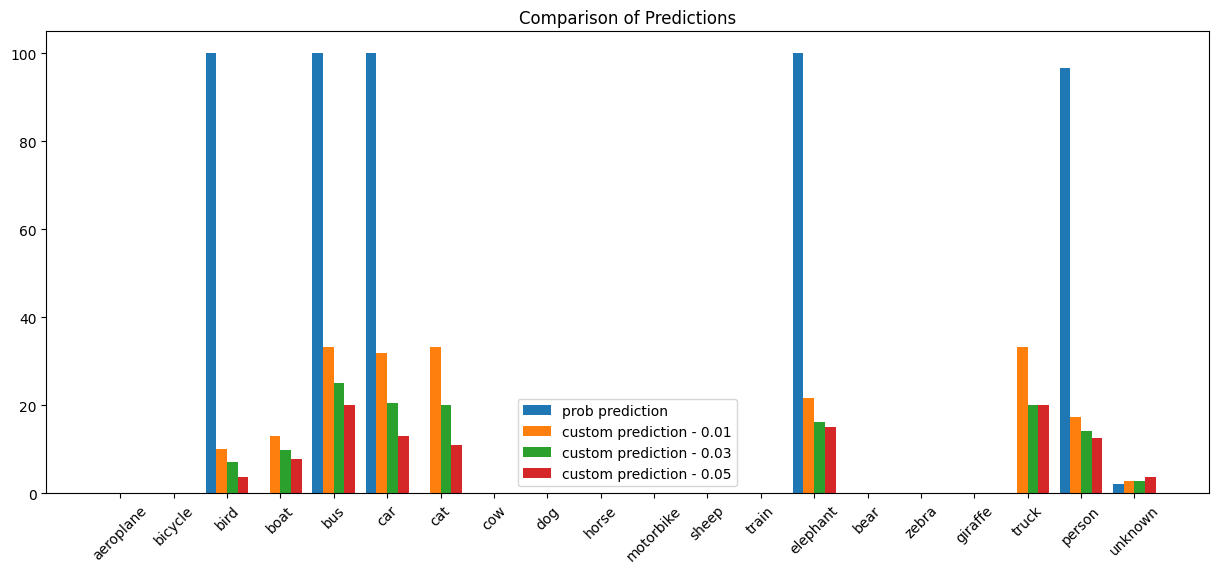

In [50]:
import matplotlib.pyplot as plt
from collections import defaultdict

labels = [
    "prob prediction",
    "custom prediction - 0.01",
    "custom prediction - 0.03",
    "custom prediction - 0.05"
]


# Extract 50-key values from each dictionary
values_list = [list(data[50]) for data in precsion_group]

# Filter out the values from indices 20-80
filtered_values_list = []
for values in values_list:
    filtered_values_list.append(values[:19] + [values[-1]])

# X-axis labels
x_label = [
    "aeroplane","bicycle","bird","boat","bus","car",
    "cat","cow","dog","horse","motorbike","sheep","train",
    "elephant","bear","zebra","giraffe","truck","person",
    "unknown"
]

# Number of bars
n_bars = len(filtered_values_list[0])

# Width of each bar
width = 0.2

# Create a new figure
fig, ax = plt.subplots(figsize=(15, 6))

# For each set of values, create a bar plot
for i, (values, label) in enumerate(zip(filtered_values_list, labels)):
    print(values)
    ax.bar([xi + i*width for xi in range(n_bars)], values, width=width, label=label)

# Set the x-axis ticks, labels, title, and legend
ax.set_xticks([xi + 1.5*width for xi in range(n_bars)])
ax.set_xticklabels(x_label, rotation=45)
ax.set_title("Comparison of Predictions")
ax.legend()

# Display the plot
plt.show()
